In [16]:
import numpy as np
import pandas as pd
import math
from matplotlib import pyplot as plt
import pickle
import gzip
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.callbacks import EarlyStopping, TensorBoard
from keras.utils import np_utils
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix  
from sklearn.ensemble import RandomForestClassifier
from PIL import Image
import os
import itertools
import seaborn as sn

In [32]:
def plot_confusion_matrix(TestingTarget, y_pred):

    arr = confusion_matrix(TestingTarget, y_pred)
    xticks = np.arange(10)
    yticks = np.arange(10)

    plt.figure(figsize = (10,7))
    sn.heatmap(arr, annot=True, fmt="d",cmap="Blues", xticklabels=xticks, yticklabels=yticks)
    
    
def plot_classification_report(TestingTarget, y_pred):
    plt.figure(figsize=(10,7))

    xticks = ['precision', 'recall', 'f1-score', 'support']
    yticks = ['0','1', '2', '3' ,'4', '5', '6', '7', '8', '9', 'average']

    rep = np.array(precision_recall_fscore_support(TestingTarget, y_pred)).T
    avg = np.mean(rep, axis=0)
    avg[-1] = np.sum(rep[:, -1])
    rep = np.insert(rep, rep.shape[0], avg, axis=0)

    t_rep = rep.T
    vmin = min(np.min(t_rep[0]), np.min(t_rep[1]), np.min(t_rep[2]))
    vmax = max(np.max(t_rep[0]), np.max(t_rep[1]), np.max(t_rep[2]))

    sn.heatmap(rep,
            annot=True, 
            cbar=True, 
            xticklabels=xticks, 
            yticklabels=yticks,fmt=".2f",cmap="OrRd",vmin=vmin, vmax=vmax)

# Pre-process: MNIST DATA

In [34]:
filename = 'mnist.pkl.gz'
f = gzip.open(filename, 'rb')
__training_data, __validation_data, __test_data = pickle.load(f, encoding='latin1')
f.close()

TrainingData = __training_data[0]
TrainingTarget = __training_data[1]

ValidationData = __validation_data[0]
ValidationTarget = __validation_data[1]

TestingData = __test_data[0]
TestingTarget = __test_data[1]


print("=========================")
print("== MNIST Dataset ==")
print("=========================")
print("TrainingData : " + str(TrainingData.shape))
print("TrainingTarget : " + str(TrainingTarget.shape))
print("ValidationData : " + str(ValidationData.shape))
print("ValidationTarget : " + str(ValidationTarget.shape))
print("TestingData : " + str(TestingData.shape))
print("TestingTarget : " + str(TestingTarget.shape))

== MNIST Dataset ==
TrainingData : (50000, 784)
TrainingTarget : (50000,)
ValidationData : (10000, 784)
ValidationTarget : (10000,)
TestingData : (10000, 784)
TestingTarget : (10000,)


# Pre-process: USPS Data

In [35]:
USPSMat  = []
USPSTar  = []
curPath  = 'USPSdata/Numerals'
savedImg = []

for j in range(0,10):
    curFolderPath = curPath + '/' + str(j)
    imgs =  os.listdir(curFolderPath)
    for img in imgs:
        curImg = curFolderPath + '/' + img
        if curImg[-3:] == 'png':
            img = Image.open(curImg,'r')
            img = img.resize((28, 28))
            savedImg = img
            imgdata = (255-np.array(img.getdata()))/255
            USPSMat.append(imgdata)
            USPSTar.append(j)

USPS_Testing_data = np.asarray(USPSMat)
USPS_Testing_target = np.asarray(USPSTar)

print("=========================")
print("==== USPS Dataset ==")
print("=========================")
print("USPS_Testing_data : " + str(USPS_Testing_data.shape))
print("USPS_Testing_target : " + str(USPS_Testing_target.shape))

==== USPS Dataset ==
USPS_Testing_data : (19999, 784)
USPS_Testing_target : (19999,)


#  Definition: Mini-batch Stochastic Gradient Descent

In [36]:
class MiniBatchSGD:
    def __init__(self, _no_of_classes =10,_learning_rate = 0.05, _mini_batch=32):
        self.no_of_classes = _no_of_classes
        self.learning_rate = _learning_rate
        self.mini_batch = _mini_batch
        
    def softmax(self, z):
    
        numerator = np.exp (z)
        demominator =  np.exp(z).sum(axis=0)

        return numerator/demominator
        
    def train_model(self, _TrainingData, _TrainingTarget, _loop_range):
        
        
        no_of_samples = _TrainingData.shape[0]
        
        bias = np.ones([no_of_samples,1])
        
        _TrainingData = np.concatenate((_TrainingData, bias), axis=1)
        
#         print(_TrainingData.shape)
        no_of_features = _TrainingData.shape[1]
        
        
        
        W = np.ones([no_of_features, self.no_of_classes])
        W_NOW = np.transpose(W)

        _TrainingTargetVector =  (np.arange(np.max(_TrainingTarget) + 1) == _TrainingTarget[:, None]).astype(float)

        _loop_range = min(_loop_range, (int) (no_of_samples/self.mini_batch))


        for i in range(_loop_range):

            lowerbound = i*self.mini_batch
            upperbound = min(no_of_samples, (i+1)*self.mini_batch)

            _thisTrainData = _TrainingData[lowerbound:upperbound].T

            z = np.dot(W_NOW, _thisTrainData)
            predicted_values = self.softmax(z).T


            diff = np.subtract(predicted_values, _TrainingTargetVector[lowerbound:upperbound])


            _thisTrainData = _thisTrainData.reshape(no_of_features, self.mini_batch)
            diff = diff.reshape(self.mini_batch, self.no_of_classes)

            Delta_W = np.dot(_thisTrainData, diff)

            W_NOW = W_NOW - (self.learning_rate*Delta_W.T)
        
        self.weights = W_NOW
        
    def get_prediction(self, _data):
        
        no_of_samples = _data.shape[1]
        
        bias = np.ones([1, no_of_samples])
        _data = np.concatenate((_data, bias), axis=0)
        
        
        y_pred   = self.softmax(np.dot(self.weights, _data))
        return y_pred.argmax(axis=0).T
    
    def get_prediction_probability(self, _data):
        
        no_of_samples = _data.shape[1]
        
        bias = np.ones([1, no_of_samples])
        _data = np.concatenate((_data, bias), axis=0)
        
        y_pred   = self.softmax(np.dot(self.weights, _data))
        return y_pred
             
    def get_accuracy(self, _data, _target):
        
        accuracy = 0.0
        counter = 0
        
        pred_data = self.get_prediction(_data)

        for i in range (0,len(pred_data)):
            if(int(pred_data[i]) == _target[i]):
                counter+=1
        accuracy = (float((counter*100))/float(len(pred_data)))
        return accuracy



====== MNIST Dataset =====


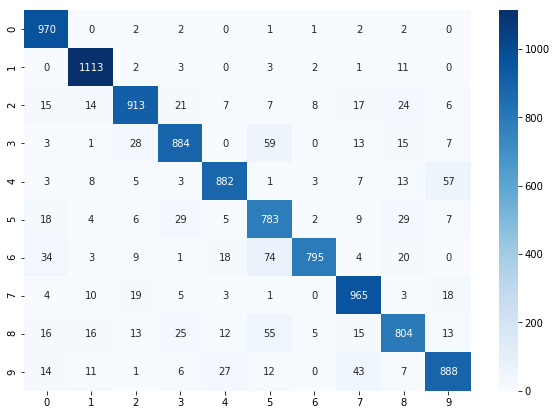

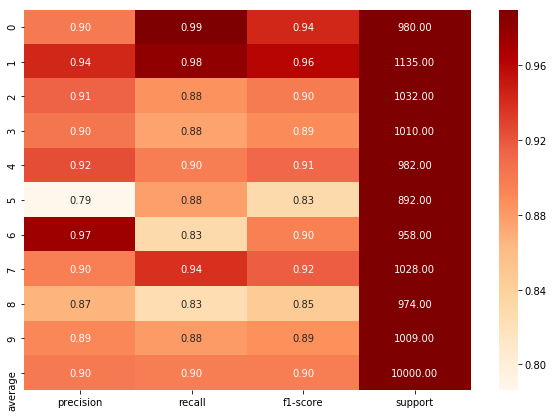

In [38]:
mini_batch_sgd = MiniBatchSGD(_no_of_classes =10,_learning_rate = 0.05, _mini_batch=50)
mini_batch_sgd.train_model(TrainingData, TrainingTarget, 1000)

# ## Testing Accuracy ##
# acc =mini_batch_sgd.get_accuracy(TestingData.T, TestingTarget)
# print(acc)
# acc =mini_batch_sgd.get_accuracy(ValidationData.T, ValidationTarget)
# print(acc)

# ## Prediction ## 
# pred = mini_batch_sgd.get_prediction(TrainingData[3])
# print(pred)

%matplotlib inline

print("==========================")
print("====== MNIST Dataset =====")
print("==========================")


y_pred = mini_batch_sgd.get_prediction(TestingData.T)

plot_confusion_matrix(TestingTarget, y_pred)
plot_classification_report(TestingTarget, y_pred)




====== USPS Dataset =====


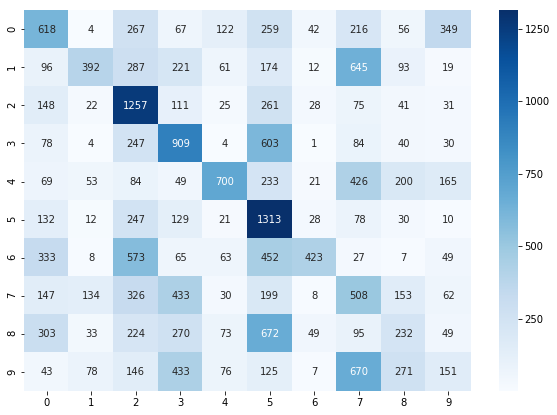

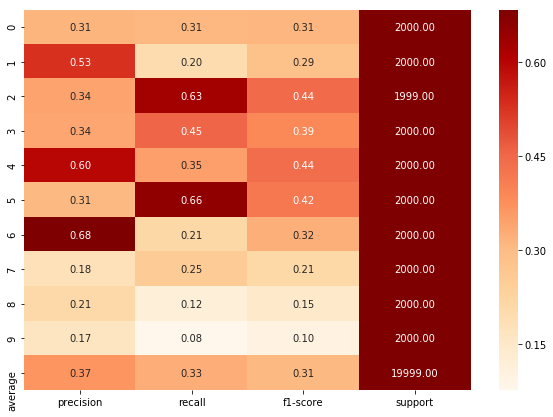

In [39]:
print("=========================")
print("====== USPS Dataset =====")
print("=========================")


y_pred = mini_batch_sgd.get_prediction(USPS_Testing_data.T)       

plot_confusion_matrix(USPS_Testing_target, y_pred)
plot_classification_report(USPS_Testing_target, y_pred)

# Definition: Neural Network

In [4]:
class NeuralNetwork:
    
    def __init__(self, input_size, drop_out, dl_1_nodes, dl_2_nodes, dl_3_nodes, 
                 opt = 'adam', loss_func = 'binary_crossentropy'):
        
        self.model = Sequential()
    
        self.model.add(Dense(dl_1_nodes, input_dim=input_size))
        self.model.add(Activation('relu'))

        self.model.add(Dropout(drop_out))

        self.model.add(Dense(dl_2_nodes))
        self.model.add(Activation('relu'))


        self.model.add(Dropout(drop_out))

        self.model.add(Dense(dl_3_nodes))
        self.model.add(Activation('softmax'))


        self.model.summary()

        self.model.compile(optimizer=opt,
                      loss= loss_func,
                      metrics=['accuracy'])
        
        
    def train_model(self, RawData, RawTarget, ValidationData, ValTargetVector, 
                    num_epochs = 10000, model_batch_size = 128, tb_batch_size = 32, early_patience = 15):
        
        tensorboard_cb   = TensorBoard(log_dir='logs', batch_size= tb_batch_size, write_graph= True)

        earlystopping_cb = EarlyStopping(monitor='val_loss', verbose=1, patience=early_patience, mode='min')

        TargetVector = np_utils.to_categorical(np.array(RawTarget), 10)

        ValTargetVector = np_utils.to_categorical(np.array(ValidationTarget), 10)


        self.history = self.model.fit(RawData
                            , TargetVector
                            , validation_data = (ValidationData, ValTargetVector)
                            , epochs=num_epochs
                            , batch_size=model_batch_size
                            , callbacks = [tensorboard_cb,earlystopping_cb]
                           )
    def plot_history(self):
        %matplotlib inline

        df = pd.DataFrame(self.history.history)
        df.plot(subplots=True, grid=True, figsize=(10,15))
        
    def get_prediction(self, TestingData):
        
        prediction = self.model.predict(TestingData)
        prediction_classes = prediction.argmax(axis=-1)
        return prediction_classes
    
    def get_prediction_probability(self, TestingData):
        
        prediction = self.model.predict(TestingData)
        return prediction
        
    def get_accuracy(self, TestingData, TestingTarget):
        
        prediction_classes = self.get_prediction(TestingData)
        score = accuracy_score(TestingTarget, prediction_classes)
        return score
        

In [ ]:
# neural_network = NeuralNetwork(input_size = TrainingData.shape[1], drop_out = 0.2, dl_1_nodes =512, dl_2_nodes =256, dl_3_nodes =10, 
#                  opt = 'adam', loss_func = 'categorical_crossentropy')

neural_network = NeuralNetwork(input_size = TrainingData.shape[1], drop_out = 0.2, dl_1_nodes =150, dl_2_nodes =35, dl_3_nodes =10, 
                 opt = 'adam', loss_func = 'binary_crossentropy')

neural_network.train_model(TrainingData, TrainingTarget, ValidationData, ValidationTarget)

====== MNIST Dataset =====


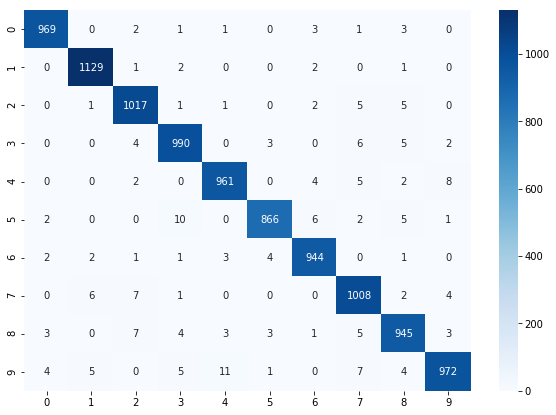

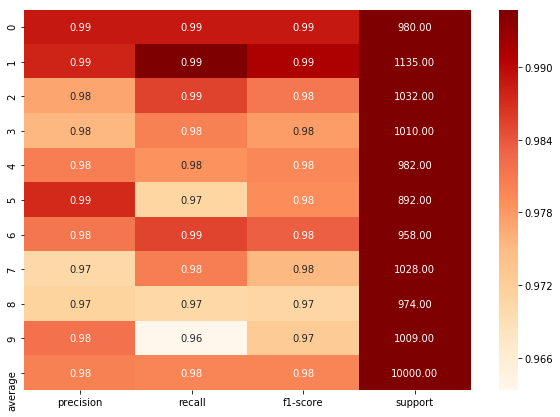

In [40]:
# neural_network.plot_history()

print("==========================")
print("====== MNIST Dataset =====")
print("==========================")

# print(neural_network.get_accuracy(TestingData, TestingTarget))
y_pred = neural_network.get_prediction(TestingData)
plot_confusion_matrix(TestingTarget, y_pred)
plot_classification_report(TestingTarget, y_pred)


====== USPS Dataset =====


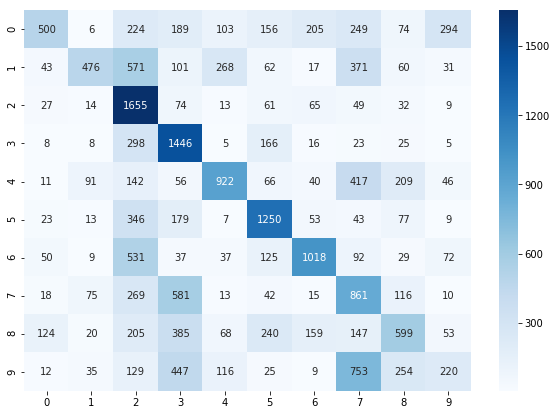

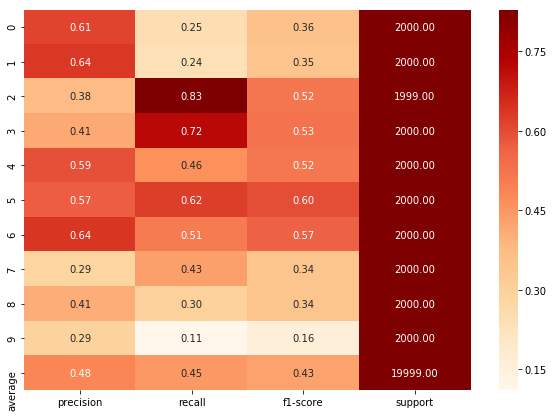

In [41]:
print("=========================")
print("====== USPS Dataset =====")
print("=========================")

# print(neural_network.get_accuracy(USPS_Testing_data, USPS_Testing_target))
y_pred = neural_network.get_prediction(USPS_Testing_data)       
plot_confusion_matrix(USPS_Testing_target, y_pred)
plot_classification_report(USPS_Testing_target, y_pred)

# Definition: Support Vector Machine (SVM)  

In [5]:
class SupportVectorMachine:
    
    def __init__(self, _kernel ='linear', _gamma = 'auto', _C = 1.0):
        
        self.svclassifier = SVC(kernel= _kernel, gamma = _gamma,  C= _C, probability=True) 
        
    def train_model(self, TrainingData, TrainingTarget):
        
        self.svclassifier.fit(TrainingData, TrainingTarget)
        
    def get_prediction(self, TestingData):
        
        y_pred = self.svclassifier.predict(TestingData)
        return y_pred
    
    def get_prediction_probability(self, TestingData):
        
        y_pred = self.svclassifier.predict_proba(TestingData)
        return y_pred
    
    def get_accuracy(self, TestingData, TestingTarget):
        
        y_pred = self.get_prediction(TestingData)
        acc = accuracy_score(TestingTarget, y_pred)
        return acc

In [ ]:
# support_vector_machine = SupportVectorMachine(_kernel ='linear')
# support_vector_machine = SupportVectorMachine(_kernel ='rbf', _gamma = 1.0)
# support_vector_machine = SupportVectorMachine(_kernel ='rbf')
support_vector_machine = SupportVectorMachine(_kernel ='rbf', _gamma = 0.05, _C = 2.0)

support_vector_machine.train_model(TrainingData, TrainingTarget)

In [ ]:
print("==========================")
print("====== MNIST Dataset =====")
print("==========================")


# print(support_vector_machine.get_accuracy(TestingData, TestingTarget))

y_pred = support_vector_machine.get_prediction(TestingData)
        
plot_confusion_matrix(TestingTarget, y_pred)
plot_classification_report(TestingTarget, y_pred)





In [ ]:
print("=========================")
print("====== USPS Dataset =====")
print("=========================")

# print(support_vector_machine.get_accuracy(USPS_Testing_data, USPS_Testing_target))

y_pred = support_vector_machine.get_prediction(USPS_Testing_data)
        
plot_confusion_matrix(USPS_Testing_target, y_pred)
plot_classification_report(USPS_Testing_target, y_pred)

# Definition: Random Forest 

In [6]:
class RandomForest:
    
    def __init__(self, _n_estimators=100):
        
        self.clf_rf = RandomForestClassifier(n_estimators=_n_estimators)

    def train_model(self, TrainingData, TrainingTarget):
        
        self.clf_rf.fit(TrainingData, TrainingTarget)
        
    def get_prediction(self, TestingData):
        
        y_pred_rf = self.clf_rf.predict(TestingData)
        return y_pred_rf
    
    def get_prediction_probability(self, TestingData):
        
        y_pred_rf = self.clf_rf.predict_proba(TestingData)
        return y_pred_rf
    
    def get_accuracy(self, TestingData, TestingTarget):
        
        y_pred_rf = self.get_prediction(TestingData)
        acc_rf = accuracy_score(TestingTarget, y_pred_rf)
        return acc_rf

In [ ]:
rndom_frst = RandomForest(_n_estimators=1000)
rndom_frst.train_model(TrainingData, TrainingTarget)

====== MNIST Dataset =====


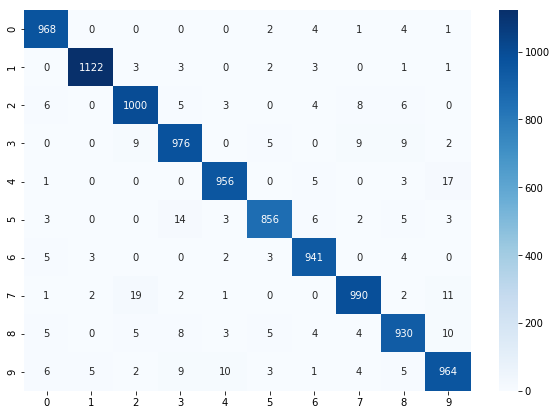

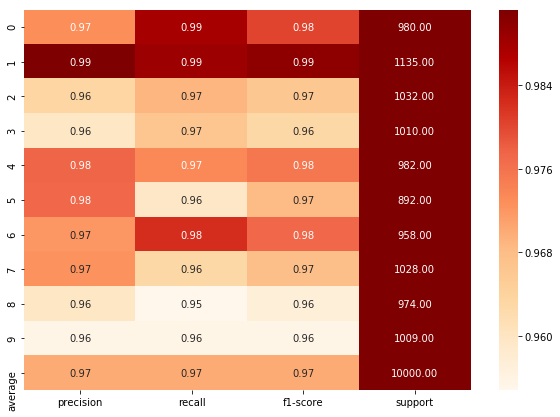

In [42]:
# rndom_frst.get_accuracy(TestingData, TestingTarget)

print("==========================")
print("====== MNIST Dataset =====")
print("==========================")


y_pred = rndom_frst.get_prediction(TestingData)
plot_confusion_matrix(TestingTarget, y_pred)
plot_classification_report(TestingTarget, y_pred)




====== USPS Dataset =====


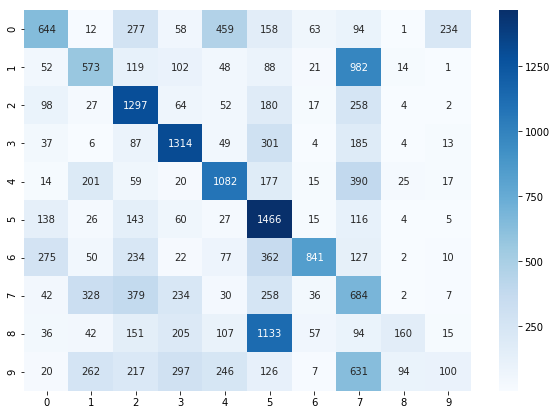

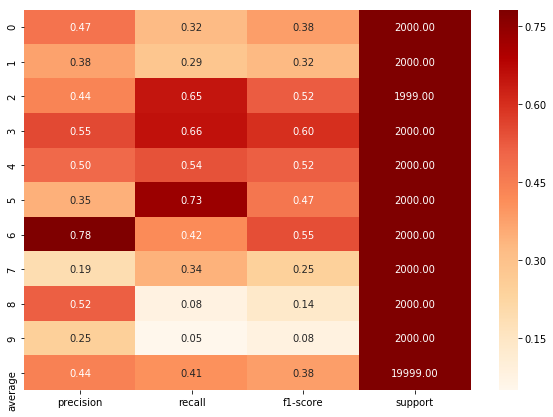

In [43]:
print("=========================")
print("====== USPS Dataset =====")
print("=========================")


y_pred = rndom_frst.get_prediction(USPS_Testing_data)       
plot_confusion_matrix(USPS_Testing_target, y_pred)
plot_classification_report(USPS_Testing_target, y_pred)

# Ensemble: Soft Voting

In [42]:
sgd_prediction_prob = mini_batch_sgd.get_prediction_probability(TestingData.T).T
nn_prediction_prob = neural_network.get_prediction_probability(TestingData)
svm_prediction_prob = support_vector_machine.get_prediction_probability(TestingData)
rf_prediction_prob = rndom_frst.get_prediction_probability(TestingData)

# print(sgd_prediction_prob.shape)
# print(nn_prediction_prob.shape)
# print(svm_prediction_prob.shape)
# print(rf_prediction_prob.shape)

sum1 = np.add(nn_prediction_prob,rf_prediction_prob)
sum2 = np.add(sum1,sgd_prediction_prob)
sum3 = np.add(sum2,svm_prediction_prob)
score = accuracy_score(TestingTarget, sum3.argmax(axis=1))

print("==========================")
print("= MNIST Dataset Accuracy =")
print("==========================")
print("Accuracy: " + str(score))



= MNIST Dataset Accuracy =
Accuracy: 0.9804


In [95]:
usps_sgd_prediction_prob = mini_batch_sgd.get_prediction_probability(USPS_Testing_data.T).T
usps_nn_prediction_prob = neural_network.get_prediction_probability(USPS_Testing_data)
usps_svm_prediction_prob = support_vector_machine.get_prediction_probability(USPS_Testing_data)
usps_rf_prediction_prob = rndom_frst.get_prediction_probability(USPS_Testing_data)

# print(usps_sgd_prediction_prob.shape)
# print(usps_nn_prediction_prob.shape)
# print(usps_svm_prediction_prob.shape)
# print(usps_rf_prediction_prob.shape)

sum1 = np.add(usps_nn_prediction_prob,usps_rf_prediction_prob)
sum2 = np.add(sum1,usps_sgd_prediction_prob)
sum3 = np.add(sum2,usps_svm_prediction_prob)
score = accuracy_score(USPS_Testing_target, sum3.argmax(axis=1))

print("==========================")
print("= USPS Dataset Accuracy =")
print("==========================")
print("Accuracy: " + str(score))

= USPS Dataset Accuracy =
Accuracy: 0.43387169358467925
